In [2]:
import itk
print(itk.Version.GetITKVersion())

5.4.0


In [3]:
import vtk
print(vtk.__version__)

9.3.0


In [4]:
import matplotlib.pyplot as plt

## Translation Transform x Regular Step Optimizer

In [101]:
def translationTransform(fixed_image_path, moving_image_path, method = "MeanSquares"):
    # Load the fixed and moving images
    fixed_image = itk.imread(fixed_image_path, itk.F)
    moving_image = itk.imread(moving_image_path, itk.F)
    
    # Define the registration components
    Dimension = 3
    FixedImageType = itk.Image[itk.F, Dimension]
    MovingImageType = itk.Image[itk.F, Dimension]
    
    TransformType = itk.TranslationTransform[itk.D, Dimension]
    initial_transform = TransformType.New()
    
    OptimizerType = itk.RegularStepGradientDescentOptimizerv4[itk.D]
    optimizer = OptimizerType.New()

    if method == "MeanSquares":
        metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
    elif method == "MattesMutualInformation":
        metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()
    
    RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType]
    registration = RegistrationType.New()

    # Set up the registration
    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)
    registration.SetInitialTransform(initial_transform)
    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)
    
    # Define the optimizer parameters
    optimizer.SetLearningRate(4.0)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(200)

    registration.Update()

    return registration.GetTransform(), metric.GetValue()

In [56]:
# Get the resulting transformation
final_transform, metric_diff = translationTransform("./Data/case6_gre1.nrrd", "./Data/case6_gre2.nrrd", method)

# Resample the moving image to align with the fixed image
ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
resampler = ResampleFilterType.New()
resampler.SetTransform(final_transform)
resampler.SetInput(moving_image)
resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
resampler.SetOutputOrigin(fixed_image.GetOrigin())
resampler.SetOutputSpacing(fixed_image.GetSpacing())
resampler.SetOutputDirection(fixed_image.GetDirection())
resampler.SetDefaultPixelValue(0)

# Save the registered image
output_image_path = './Data/case6_gre2_registered_trsl.nrrd'
itk.imwrite(resampler.GetOutput(), output_image_path)

print("Registration completed successfully.")

Registration completed successfully.


## Affine Transform x Regular Step Optimizer x Shrink

In [114]:
def affineTransform(fixed_image_path, moving_image_path, method = "MeanSquares", shrink = False):
    fixed_image = itk.imread(fixed_image_path, itk.F)
    moving_image = itk.imread(moving_image_path, itk.F)
    
    # Define the registration components
    Dimension = 3
    FixedImageType = itk.Image[itk.F, Dimension]
    MovingImageType = itk.Image[itk.F, Dimension]
    
    TransformType = itk.AffineTransform[itk.D, Dimension]
    initial_transform = TransformType.New()
    initial_transform.SetIdentity()
    
    OptimizerType = itk.RegularStepGradientDescentOptimizerv4[itk.D]
    optimizer = OptimizerType.New()
    
    if method == "MeanSquares":
        metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
    elif method == "MattesMutualInformation":
        metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()
    
    RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType]
    registration = RegistrationType.New()
    
    # Set up the registration
    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)
    registration.SetInitialTransform(initial_transform)
    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)
    
    # Define the optimizer parameters
    optimizer.SetLearningRate(1.0)
    optimizer.SetMinimumStepLength(0.01)
    optimizer.SetNumberOfIterations(200)

    if shrink:
        # Define the shrink factors for each level
        shrink_factors_per_level = [4, 2, 1]
        
        # Define the smoothing sigmas for each level
        smoothing_sigmas_per_level = [2, 1, 0]
        
        registration.SetShrinkFactorsPerLevel(shrink_factors_per_level)
        registration.SetSmoothingSigmasPerLevel(smoothing_sigmas_per_level)

    # Start the registration process
    registration.Update()

    return registration.GetTransform(), metric.GetValue()

In [37]:
# Get the resulting transformation
final_transform = registration.GetTransform()

# Resample the moving image to align with the fixed image
ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
resampler = ResampleFilterType.New()
resampler.SetTransform(final_transform)
resampler.SetInput(moving_image)
resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
resampler.SetOutputOrigin(fixed_image.GetOrigin())
resampler.SetOutputSpacing(fixed_image.GetSpacing())
resampler.SetOutputDirection(fixed_image.GetDirection())
resampler.SetDefaultPixelValue(0)
# resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=final_transform, UseReferenceImage=True, ReferenceImage=fixed_image)

# Save the registered image
output_image_path = './Data/case6_gre2_registered_aff_shrk_rsmp.nrrd'
itk.imwrite(resampler.GetOutput(), output_image_path)

print("Registration completed successfully.")

Registration completed successfully.


## Rigid Transform

In [110]:
def rigidTransform(fixed_image_path, moving_image_path, method = "MeanSquares"):
    fixed_image = itk.imread(fixed_image_path, itk.F)
    moving_image = itk.imread(moving_image_path, itk.F)
    
    # Define the registration components
    Dimension = 3
    FixedImageType = itk.Image[itk.F, Dimension]
    MovingImageType = itk.Image[itk.F, Dimension]
    
    RigidTransformType = itk.VersorRigid3DTransform[itk.D]
    TransformInitializerType = itk.CenteredTransformInitializer[RigidTransformType, FixedImageType, MovingImageType]

    OptimizerType = itk.RegularStepGradientDescentOptimizer
    optimizer = OptimizerType.New()
    
    if method == "MeanSquares":
        metric = itk.MeanSquaresImageToImageMetric[FixedImageType, MovingImageType].New()
    elif method == "MattesMutualInformation":
        metric = itk.MattesMutualInformationImageToImageMetric[FixedImageType, MovingImageType].New()
    
    InterpolatorType = itk.LinearInterpolateImageFunction[MovingImageType, itk.D]
    interpolator = InterpolatorType.New()
    
    RegistrationType = itk.ImageRegistrationMethod[FixedImageType, MovingImageType]
    registration = RegistrationType.New()
    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)
    registration.SetInterpolator(interpolator)

    IdentityTransformType = itk.IdentityTransform[itk.D, Dimension]
    identityTransform = IdentityTransformType.New()
    
    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)

    if method == "MattesMututalInformation":
        metric.SetNumberOfHistogramBins(50)
    
    fixedRegion = fixed_image.GetBufferedRegion()
    numberOfPixels = fixedRegion.GetNumberOfPixels()
    metric.ReinitializeSeed(76926294)

    initializer = TransformInitializerType.New()
    rigidTransform = RigidTransformType.New()
    
    initializer.SetTransform(rigidTransform)
    initializer.SetFixedImage(fixed_image)
    initializer.SetMovingImage(moving_image)
    initializer.MomentsOn()

    initializer.InitializeTransform()
    registration.SetFixedImageRegion(fixedRegion)
    registration.SetInitialTransformParameters(rigidTransform.GetParameters())
    
    registration.SetTransform(rigidTransform)

    number_of_parameters = rigidTransform.GetNumberOfParameters()
    optimizerScales = [1.0] * number_of_parameters
    translationScale = 1.0 / 1000.0
    optimizerScales[3] = translationScale
    optimizerScales[4] = translationScale
    optimizerScales[5] = translationScale

    optimizer.SetScales(optimizerScales)
    
    optimizer.SetMaximumStepLength(0.2000)
    optimizer.SetMinimumStepLength(0.0001)
    
    optimizer.SetNumberOfIterations(200)

    metric.SetNumberOfSpatialSamples(10000)
    registration.Update()

    final_transform = registration.GetModifiableTransform()
    final_parameters = final_transform.GetParameters()

    # Compute the metric value
    metric_value = metric.GetValue(final_parameters)
    
    return final_transform, metric_value

In [32]:
# rigidTransform.SetParameters(registration.GetLastTransformParameters())

In [33]:
# Get the resulting transformation
# final_transform = registration.GetTransform()

# Resample the moving image to align with the fixed image
# ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
# resampler = ResampleFilterType.New()
# resampler.SetTransform(final_transform)
# resampler.SetInput(moving_image)
# resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
# resampler.SetOutputOrigin(fixed_image.GetOrigin())
# resampler.SetOutputSpacing(fixed_image.GetSpacing())
# resampler.SetOutputDirection(fixed_image.GetDirection())
# resampler.SetDefaultPixelValue(0)

final_transform = RigidTransformType.New()
final_transform.SetParameters(registration.GetLastTransformParameters())
final_transform.SetFixedParameters(rigidTransform.GetFixedParameters())

ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
resampler = ResampleFilterType.New()
resampler.SetTransform(final_transform)
resampler.SetInput(moving_image)
resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
resampler.SetOutputOrigin(fixed_image.GetOrigin())
resampler.SetOutputSpacing(fixed_image.GetSpacing())
resampler.SetOutputDirection(fixed_image.GetDirection())
# resampler.SetDefaultPixelValue(0)
resampler.SetDefaultPixelValue(100)

# Save the registered image
output_image_path = './Data/case6_gre2_registered_rigid.nrrd'
itk.imwrite(resampler.GetOutput(), output_image_path)

print("Registration completed successfully.")

Registration completed successfully.


In [34]:
OutputPixelType = itk.US
OutputImageType = itk.Image[OutputPixelType, Dimension]

caster = itk.CastImageFilter[FixedImageType, OutputImageType].New()
writer = itk.ImageFileWriter[OutputImageType].New()

writer.SetFileName('./Data/case6_gre2_registered_rigid.nrrd')
caster.SetInput(resampler.GetOutput())
writer.SetInput(caster.GetOutput())
writer.Update()

In [35]:
difference_filter = itk.SubtractImageFilter[FixedImageType, FixedImageType, FixedImageType].New()
difference_filter.SetInput1(fixed_image)
difference_filter.SetInput2(resampler.GetOutput())

writer2 = itk.ImageFileWriter[OutputImageType].New()

intensity_rescaler = itk.RescaleIntensityImageFilter[FixedImageType, OutputImageType].New()
intensity_rescaler.SetInput(difference_filter.GetOutput())
intensity_rescaler.SetOutputMinimum(0)
intensity_rescaler.SetOutputMaximum(255)

writer2.SetInput(intensity_rescaler.GetOutput())
resampler.SetDefaultPixelValue(1)

In [39]:
!rm "./Data/case6_gre2_differenceafter.nrrd" "./Data/case6_gre2_differencebefore.nrrd"

In [36]:
writer2.SetFileName("./Data/case6_gre2_differenceafter.nrrd")
writer2.Update()

In [40]:
resampler.SetTransform(identityTransform)
writer2.SetFileName("./Data/case6_gre2_differencebefore.nrrd")
writer2.Update()

## Compare methods

In [90]:
fixed_image_path = "./Data/case6_gre1.nrrd"
moving_image_path = "./Data/case6_gre2.nrrd"

In [115]:
# Perform registrations using different methods
methods = ["MeanSquares", "MattesMutualInformation"]
results = {}

for method in methods:
    final_transform, metric_value = affineTransform(fixed_image_path, moving_image_path, method)
    results[method] = {
        "transform": final_transform,
        "metric_value": metric_value
    }

# Display results
for method, result in results.items():
    print(f"Method: {method}")
    print(f"Metric Value: {result['metric_value']}")
    print(f"Final Transform: {result['transform']}")

Method: MeanSquares
Metric Value: 58473.65565878661
Final Transform: AffineTransform (0x594eaf30e380)
  RTTI typeinfo:   itk::AffineTransform<double, 3u>
  Reference Count: 1
  Modified Time: 403692
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    0.0844263 -0.42999 0.42304 
    0.00587511 1.2513 0.408026 
    0.0178565 1.00551 0.571988 
  Offset: [-0.0127087, -0.135661, -0.131211]
  Center: [0, 0, 0]
  Translation: [-0.0127087, -0.135661, -0.131211]
  Inverse: 
    17.8136 39.1506 -41.1029 
    0.228926 2.37573 -1.86403 
    -0.958543 -5.39856 6.30827 
  Singular: 0

Method: MattesMutualInformation
Metric Value: -0.3135548308207894
Final Transform: AffineTransform (0x594eb564b400)
  RTTI typeinfo:   itk::AffineTransform<double, 3u>
  Reference Count: 1
  Modified Time: 406663
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    0.926349 -0.188654 -0.0656999 
    0.162011 0.866827 -0.215681 
    0.223004 0.348501 0.529077 
  Offset: [-0.00259433, -0.0415

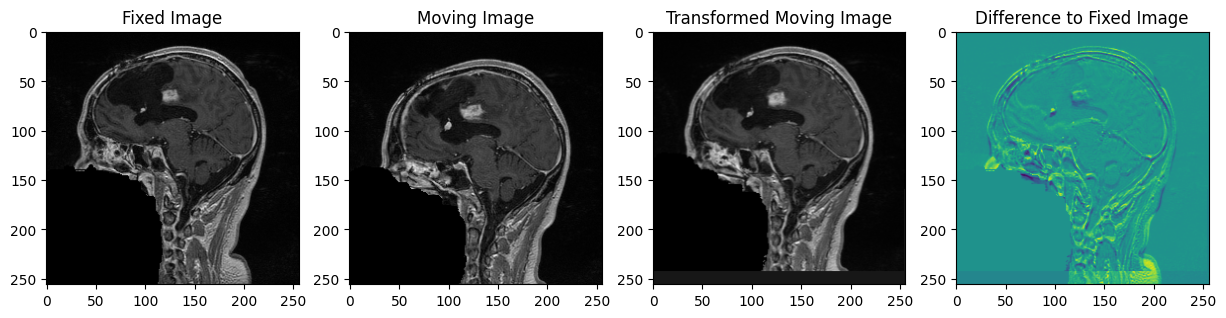

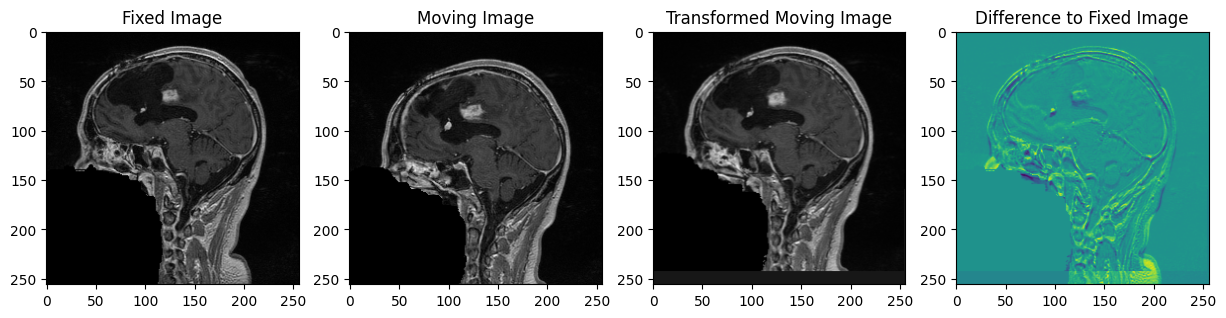

In [113]:
def show_images(fixed_image, moving_image, transformed_moving_image):
    fixed_array = itk.array_view_from_image(fixed_image)
    moving_array = itk.array_view_from_image(moving_image)
    transformed_moving_array = itk.array_view_from_image(transformed_moving_image)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(fixed_array[80, :, :], cmap='gray')
    axes[0].set_title('Fixed Image')

    axes[1].imshow(moving_array[80, :, :], cmap='gray')
    axes[1].set_title('Moving Image')

    axes[2].imshow(transformed_moving_array[80, :, :], cmap='gray')
    axes[2].set_title('Transformed Moving Image')

    axes[3].imshow(fixed_array[80, :, :] - transformed_moving_array[80, :, :], cmap='viridis')
    axes[3].set_title('Difference to Fixed Image')

    plt.show()

# Apply the transformation and visualize
fixed_image = itk.imread(fixed_image_path, itk.F)
moving_image = itk.imread(moving_image_path, itk.F)

for method, result in results.items():
    transform = result['transform']
    
    # ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
    # resampler = ResampleFilterType.New()
    # resampler.SetTransform(transform)
    # resampler.SetInput(moving_image)
    # resampler.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    # resampler.SetOutputOrigin(fixed_image.GetOrigin())
    # resampler.SetOutputSpacing(fixed_image.GetSpacing())
    # resampler.SetOutputDirection(fixed_image.GetDirection())
    # resampler.SetDefaultPixelValue(0)
    resampler.SetDefaultPixelValue(100)
    resampler.Update()
    
    transformed_moving_image = resampler.GetOutput()
    show_images(fixed_image, moving_image, transformed_moving_image)

## Visualization

In [59]:
def show(images_path, PixelType = itk.US, n_slice = 80):
    fig = plt.figure(figsize=(10, 10))
    columns = 3
    rows = len(images_path) // columns + 1
    for i in range(0, len(images_path)):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(itk.imread(images_path[i], PixelType)[n_slice, :, :])
    plt.show()

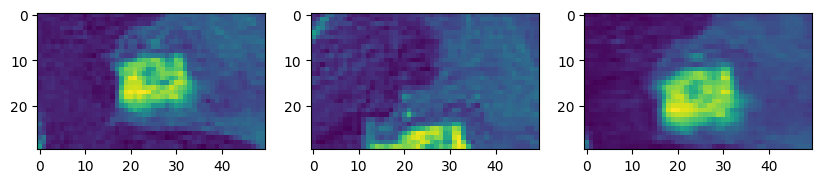

In [49]:
show(["./Data/case6_gre1.nrrd", "./Data/case6_gre2.nrrd", "./Data/case6_gre2_registered_rigid.nrrd"], n_slice=80)#, "./Data/case6_gre2_differenceafter.nrrd", "./Data/case6_gre2_differencebefore.nrrd"])

### other images

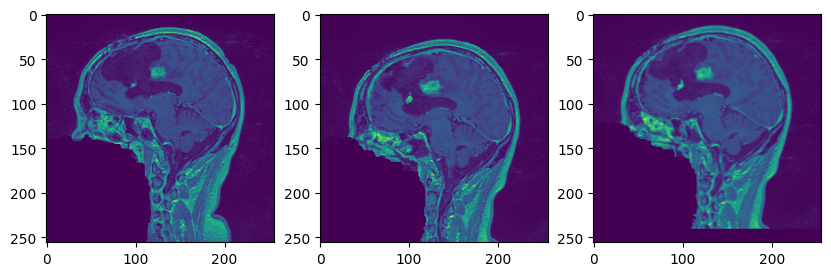

In [60]:
show(["./Data/case6_gre1.nrrd", "./Data/case6_gre2.nrrd", "./Data/case6_gre2_registered_trsl.nrrd"])

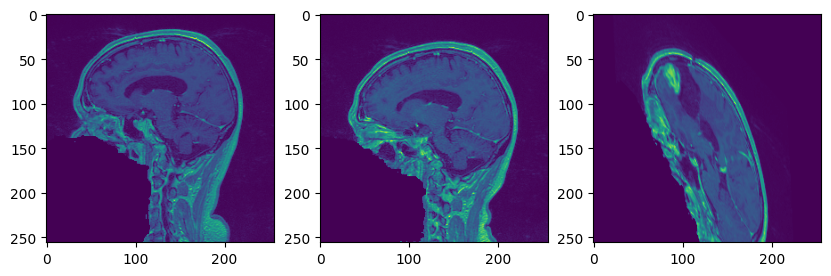

In [20]:
show(["./Data/case6_gre1.nrrd", "./Data/case6_gre2.nrrd", "./Data/case6_gre2_registered_aff_shrk.nrrd"])

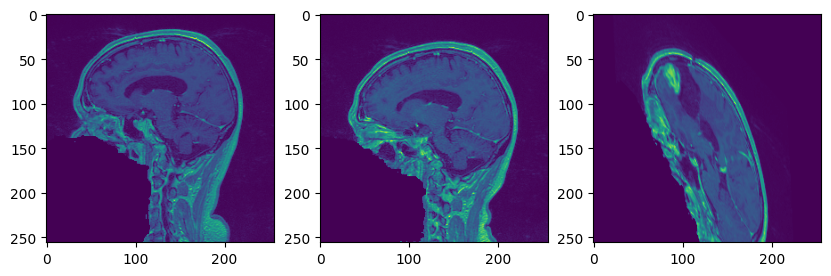

In [38]:
show(["./Data/case6_gre1.nrrd", "./Data/case6_gre2.nrrd", "./Data/case6_gre2_registered_aff_shrk_rsmp.nrrd"])

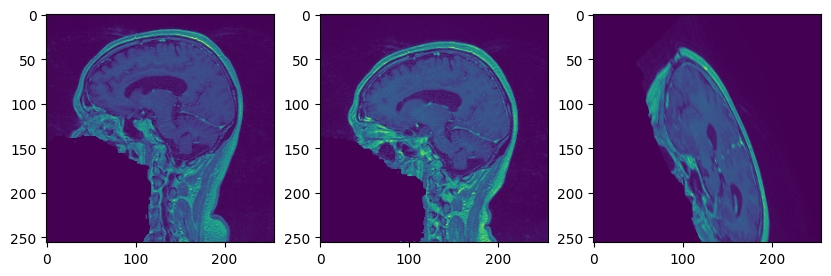

In [32]:
show(["./Data/case6_gre1.nrrd", "./Data/case6_gre2.nrrd", "./Data/case6_gre2_registered_aff_rsmp.nrrd"])

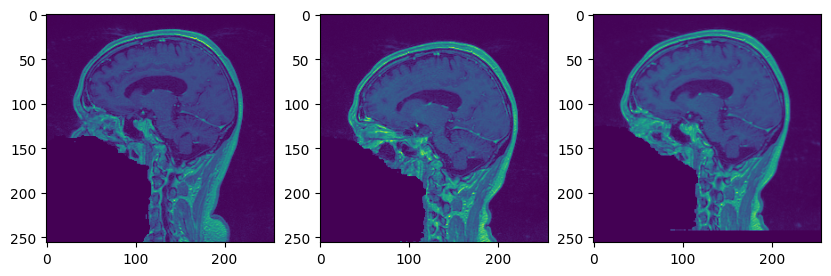

In [95]:
show(["./Data/case6_gre1.nrrd", "./Data/case6_gre2.nrrd", "./Data/case6_gre2_registered_rigid.nrrd"])

## 3D Visualisation

In [151]:
brain_image1 = vtk.vtkNrrdReader()
brain_image1.SetFileName("./Data/case6_gre1.nrrd")
brain_image1.Update()

brain_image2 = vtk.vtkNrrdReader()
brain_image2.SetFileName("./Data/case6_gre2_registered_rigid.nrrd")
brain_image2.Update()

tumor_mask1 = vtk.vtkNrrdReader()
tumor_mask1.SetFileName("./Data/case6_gre1_result.nrrd")
tumor_mask1.Update()

tumor_mask2 = vtk.vtkNrrdReader()
tumor_mask2.SetFileName("./Data/case6_gre2_result.nrrd")
tumor_mask2.Update()

In [152]:
(xMin, xMax, yMin, yMax, zMin, zMax) = brain_image1.GetExecutive().GetWholeExtent(brain_image1.GetOutputInformation(0))
(xSpacing, ySpacing, zSpacing) = brain_image1.GetOutput().GetSpacing()
(x0, y0, z0) = brain_image1.GetOutput().GetOrigin()

center = [x0 + xSpacing * 0.5 * (xMin + xMax),
          y0 + ySpacing * 0.5 * (yMin + yMax),
          z0 + zSpacing * 0.5 * (zMin + zMax)]

In [153]:
# Matrices for sagittal, axial, coronal view orientations
sagittal = vtk.vtkMatrix4x4()
sagittal.DeepCopy((1, 0, 0, center[0],
                   0,-1, 0, center[1],
                   0, 0, 1, center[2],
                   0, 0, 0, 1))

In [154]:
# Create renderers for each image
renderer1 = vtk.vtkRenderer()
renderer2 = vtk.vtkRenderer()

# Create render window and interactor
render_window = vtk.vtkRenderWindow()
render_window.SetSize(800, 400)  # Set window size to accommodate side by side views

render_window.AddRenderer(renderer1)
render_window.AddRenderer(renderer2)

# Set the viewport for side by side visualization
renderer1.SetViewport(0.0, 0.0, 0.5, 1.0)
renderer2.SetViewport(0.5, 0.0, 1.0, 1.0)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# Function to create a lookup table to map mask values to red color
def create_lookup_table():
    lut = vtk.vtkLookupTable()
    lut.SetNumberOfTableValues(2)
    lut.SetTableValue(0, 0.0, 0.0, 0.0, 0.0)  # Background: transparent
    lut.SetTableValue(1, 1.0, 0.0, 0.0, 0.7)  # Tumor: red with opacity
    lut.Build()
    return lut

In [155]:
def lut_actor():
    lut = vtk.vtkLookupTable()
    lut.SetRange(0, 500)
    lut.SetValueRange(0.0, 1.0)
    lut.SetSaturationRange(0.0, 0.0) # no color saturation
    lut.SetRampToLinear()
    lut.Build()
    return lut

In [156]:
reslice1 = vtk.vtkImageReslice()
reslice1.SetInputData(brain_image1.GetOutput())# Matrices for sagittal, axial, coronal view orientations
reslice1.SetOutputDimensionality(2)
reslice1.SetResliceAxes(sagittal) # Change view here (axial, sagittal, coronal)
reslice1.SetInterpolationModeToLinear()

reslice1_mask = vtk.vtkImageReslice()
reslice1_mask.SetInputData(tumor_mask1.GetOutput())# Matrices for sagittal, axial, coronal view orientations
reslice1_mask.SetOutputDimensionality(2)
reslice1_mask.SetResliceAxes(sagittal) # Change view here (axial, sagittal, coronal)
reslice1_mask.SetInterpolationModeToLinear()

color1 = vtk.vtkImageMapToColors()
color1.SetLookupTable(lut_actor())
color1.SetInputConnection(reslice1.GetOutputPort())

# Create the image actor
image_actor1 = vtk.vtkImageActor()
image_actor1.GetMapper().SetInputConnection(color1.GetOutputPort())
image_actor1.GetProperty().SetOpacity(0.5)  # Light white

# Create a lookup table and map the mask to colors
lut1 = create_lookup_table()
map_to_colors1 = vtk.vtkImageMapToColors()
map_to_colors1.SetInputData(reslice1_mask.GetOutput())
map_to_colors1.SetLookupTable(lut1)
map_to_colors1.Update()

# Create the mask actor
mask_actor1 = vtk.vtkImageActor()
mask_actor1.GetMapper().SetInputConnection(map_to_colors1.GetOutputPort())

# Add actors to the renderer
renderer1.AddActor(image_actor1)
renderer1.AddActor(mask_actor1)

In [157]:
reslice2 = vtk.vtkImageReslice()
reslice2.SetInputData(brain_image2.GetOutput())# Matrices for sagittal, axial, coronal view orientations
reslice2.SetOutputDimensionality(2)
reslice2.SetResliceAxes(sagittal) # Change view here (axial, sagittal, coronal)
reslice2.SetInterpolationModeToLinear()

reslice2_mask = vtk.vtkImageReslice()
reslice2_mask.SetInputData(tumor_mask2.GetOutput())# Matrices for sagittal, axial, coronal view orientations
reslice2_mask.SetOutputDimensionality(2)
reslice2_mask.SetResliceAxes(sagittal) # Change view here (axial, sagittal, coronal)
reslice2_mask.SetInterpolationModeToLinear()

color2 = vtk.vtkImageMapToColors()
color2.SetLookupTable(lut_actor())
color2.SetInputConnection(reslice2.GetOutputPort())

# Create the image actor
image_actor2 = vtk.vtkImageActor()
image_actor2.GetMapper().SetInputConnection(color2.GetOutputPort())
image_actor2.GetProperty().SetOpacity(0.5)  # Light white

# Create a lookup table and map the mask to colors
lut2 = create_lookup_table()
map_to_colors2 = vtk.vtkImageMapToColors()
map_to_colors2.SetInputData(reslice2_mask.GetOutput())
map_to_colors2.SetLookupTable(lut2)
map_to_colors2.Update()

# Create the mask actor
mask_actor2 = vtk.vtkImageActor()
mask_actor2.GetMapper().SetInputConnection(map_to_colors2.GetOutputPort())

# Add actors to the renderer
renderer2.AddActor(image_actor2)
renderer2.AddActor(mask_actor2)

In [158]:
interactorStyle = vtk.vtkInteractorStyleImage()
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetInteractorStyle(interactorStyle)
render_window.SetInteractor(interactor)
render_window.Render()

In [159]:
# Create callbacks for slicing the image
actions = {}
actions["Slicing"] = 0

def ButtonCallback(obj, event):
    if event == "LeftButtonPressEvent":
        actions["Slicing"] = 1
    else:
        actions["Slicing"] = 0

def MouseMoveCallback(obj, event):
    (lastX, lastY) = interactor.GetLastEventPosition()
    (mouseX, mouseY) = interactor.GetEventPosition()
    if actions["Slicing"] == 1:
        deltaY = mouseY - lastY
        def update_slice(reslice):
            reslice.Update()
            sliceSpacing = reslice.GetOutput().GetSpacing()[2]
            matrix = reslice.GetResliceAxes()
            # move the center point that we are slicing through
            center = matrix.MultiplyPoint((0, 0, sliceSpacing * deltaY, 1))
            matrix.SetElement(0, 3, center[0])
            matrix.SetElement(1, 3, center[1])
            matrix.SetElement(2, 3, center[2])

        update_slice(reslice1)
        update_slice(reslice1_mask)
        update_slice(reslice2)
        update_slice(reslice2_mask)
        render_window.Render()
    else:
        interactorStyle.OnMouseMove()

interactorStyle.AddObserver("MouseMoveEvent", MouseMoveCallback)
interactorStyle.AddObserver("LeftButtonPressEvent", ButtonCallback)
interactorStyle.AddObserver("LeftButtonReleaseEvent", ButtonCallback)

6

In [160]:
# Start interaction
interactor.Start()
del render_window
# del renderer
del interactor